In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"roshanupadhyay07","key":"24064c54065446c889ac2c912e483f8c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/car-plate-detection

 99% 202M/203M [00:10<00:00, 24.6MB/s]
100% 203M/203M [00:10<00:00, 21.0MB/s]


In [ ]:
!unzip car-plate-detection.zip -d /content/car-plate-detection/

Archive:  car-plate-detection.zip
  inflating: /content/car-plate-detection/annotations/Cars0.xml  
  inflating: /content/car-plate-detection/annotations/Cars1.xml  
  inflating: /content/car-plate-detection/annotations/Cars10.xml  
  inflating: /content/car-plate-detection/annotations/Cars100.xml  
  inflating: /content/car-plate-detection/annotations/Cars101.xml  
  inflating: /content/car-plate-detection/annotations/Cars102.xml  
  inflating: /content/car-plate-detection/annotations/Cars103.xml  
  inflating: /content/car-plate-detection/annotations/Cars104.xml  
  inflating: /content/car-plate-detection/annotations/Cars105.xml  
  inflating: /content/car-plate-detection/annotations/Cars106.xml  
  inflating: /content/car-plate-detection/annotations/Cars107.xml  
  inflating: /content/car-plate-detection/annotations/Cars108.xml  
  inflating: /content/car-plate-detection/annotations/Cars109.xml  
  inflating: /content/car-plate-detection/annotations/Cars11.xml  
  inflating: /conten

In [ ]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import shutil 
from sklearn.model_selection import train_test_split
import tqdm
import yaml
import torch
from IPython.display import Image
import matplotlib.pyplot as plt 
%matplotlib inline
import os

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git  

Cloning into 'yolov5'...
remote: Enumerating objects: 15594, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 15594 (delta 95), reused 112 (delta 53), pack-reused 15393
Receiving objects: 100% (15594/15594), 14.63 MiB | 18.80 MiB/s, done.
Resolving deltas: 100% (10623/10623), done.


In [ ]:
os.chdir('/content/yolov5')

%pip install -qr requirements.txt 

os.chdir('/content/')

!pwd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
/content


In [ ]:
os.chdir("/content/yolov5")
base_dir = 'base_dir'
os.mkdir(base_dir)
# images dir
images = os.path.join(base_dir, 'images')
os.mkdir(images)
train = os.path.join(images, 'train')
os.mkdir(train)
validation = os.path.join(images, 'validation')
os.mkdir(validation)

# labels
labels = os.path.join(base_dir, 'labels')
os.mkdir(labels)
# create new folders inside labels
train = os.path.join(labels, 'train')
os.mkdir(train)
validation = os.path.join(labels, 'validation')
os.mkdir(validation)

!tree base_dir


/bin/bash: tree: command not found


In [ ]:
os.chdir("/content")
yaml_dict = {'train': 'base_dir/images/train',   # path to the train folder
            'val': 'base_dir/images/validation', # path to the val folder
            'nc': 1,                             # number of classes
            'names': ['plate']}                # list of label names

with open(r'yolov5/plate_detection.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [ ]:
def extract_size(bs_data,file_name) -> tuple:
    '''
    Takes the size tag in the xml file and
    it returns the width and height inside the box
    INPUT 
    - bs_data: bs object
    - file_name: tobe printed in case there is an error 
    OUTPUT 
    - width: int
    - height: int
    '''
    try: 
        width = list(bs_data.size.width)[0]
        height = list(bs_data.size.height)[0]
        return (int(width),int(height))
    except: 
        print(f"file with name: {file_name} \n does not have either"\
             " width or height")
        return (-1,-1)
def extract_bbox(bbox,file_name):
    '''
    This function takes the bbox tag of an object and returns 
    the vales of xs and ys 
    INPUT 
    - bbox: bs object
    - file_name: str
    OUTPUT 
    - xmin: int
    - xmax: int
    - ymin: int
    - ymax: int
    return xmin,xmax,ymin,ymax 
    '''
    try: 
        xmin = int(list(bbox.xmin)[0])
        xmax = int(list(bbox.xmax)[0])
        ymin = int(list(bbox.ymin)[0])
        ymax = int(list(bbox.ymax)[0])
        return xmin,xmax,ymin,ymax
    except: 
        print(f"file with name: {file_name} \n does not have correct"\
             " object annotation")
        return -1,-1,-1,-1
    
    

In [ ]:
def process_input(files,data_type='train'):
    os.chdir("/content/")
    base_path = '/content/car-plate-detection'

    for file in tqdm.tqdm(files):
        with open(file, 'r') as f:
                data = f.read()
        Bs_data = BeautifulSoup(data, "xml")

        # getting the size to be used in normalization 
        width,height= extract_size(Bs_data,file)
        if width==height== -1: continue #make sure that the size is valid

        yolo_data=[] 
        for bbox in Bs_data.find_all("bndbox"): 
            xmin,xmax,ymin,ymax= extract_bbox(bbox,file)
            if xmin==xmax==ymin==ymax==-1 : break

            # now lets prepare the centers and w,h 
            bbox_h = int(ymax - ymin)
            bbox_w = int(xmax - xmin)
            x_center = xmin + (bbox_w/2)
            y_center = ymin + (bbox_h/2)
            # now let's normalize
            x_center/= width
            bbox_w/= width

            y_center/= height
            bbox_h/=height

            yolo_data.append([0,x_center, y_center, bbox_w, bbox_h])


        if len(yolo_data) == 0 : contine
        yolo_data = np.array(yolo_data)
        
        imgname= file.split("/")[-1]
        imgname= imgname.split(".")[0]
        np.savetxt(os.path.join('yolov5/base_dir',
                                f"labels/{data_type}/{imgname}.txt"),
                   yolo_data,
                   fmt=["%d", "%f", "%f", "%f", "%f"]) # fmt means format the columns

            # Copy the image to images
        shutil.copyfile(
            os.path.join(base_path, f"images/{imgname}.png"),
            os.path.join('yolov5/base_dir', f"images/{data_type}/{imgname}.png"))

In [ ]:
files= [] 
for dirname, _, filenames in os.walk('/content/car-plate-detection/annotations'):
    for filename in filenames:
        name= os.path.join(dirname, filename)
        if name.endswith("xml"):
            files.append(name)


## Split and Preprocess the data <a><a name='ch4'>

In [ ]:
os.chdir("/content")
train_files, val_files = train_test_split(files, test_size=0.2, random_state=42)
print(f"# of trainning examples {len(train_files)}")
print(f"# of validation examples {len(val_files)}")


# of trainning examples 346
# of validation examples 87


In [ ]:
process_input(train_files)
process_input(val_files,"validation")

100%|██████████| 87/87 [00:00<00:00, 337.94it/s]


## Trainning The model 

In [ ]:
# What some of the parameters mean:

# --weights => the pre-trained model that we are using.
# The list of available pre-trained models can be found here:
# https://github.com/ultralytics/yolov5

# --save-txt => The predicted bbox coordinates get saved to a txt file. One txt file per image.
# --save-conf => The conf score gets included in the above txt file.
# --img => The image will be resized to this size before creating the mosaic.
# --conf => The confidence threshold
# --rect => Means don't use mosaic augmentation during training
# --name => Give a model a name e.g. --name my_model
# --batch => batch size
# --epochs => number of training epochs
# --data => the yaml file path
# --exist-ok => do not increment the project names with each run i.e. don't change exp to epx2, exp3 etc.
# --nosave => do not save the images/videos (helpful when deploying to a server)

# It's helpful to review the source code in detect.py to know what the above parameters mean.
# detect.py is located inside the yolov5 folder.

In [ ]:
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")


Setup complete. Using torch 2.0.0+cu118 (Tesla T4)


In [ ]:
# Using pre-trained weights and image cache i.e. loading all images into RAM
#!WANDB_MODE="dryrun" python train.py --img 1024 --batch 24 --epochs 10 --data plate_detection.yaml --weights yolov5s.pt --cache

# Not caching images
os.chdir("/content/yolov5")
!python train.py --img 480 --batch 128 --epochs 100 --data plate_detection.yaml --weights yolov5s.pt --device 0

train: weights=yolov5s.pt, cfg=, data=plate_detection.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=128, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-154-gf3ee596 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0

## Test the results <a><a name='ch6'>

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --source '/content/car-plate-detection/images/Cars0.png'

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/car-plate-detection/images/Cars0.png, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-154-gf3ee596 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/car-plate-detection/images/Cars0.png: 352x640 1 plate, 43.2ms
Speed: 0.4ms pre-process, 43.2ms inference, 78.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


In [ ]:
!zip -r /content/k.zip /content/yolov5/runs

  adding: content/yolov5/runs/ (stored 0%)
  adding: content/yolov5/runs/detect/ (stored 0%)
  adding: content/yolov5/runs/detect/exp/ (stored 0%)
  adding: content/yolov5/runs/detect/exp/Cars0.png (deflated 4%)
  adding: content/yolov5/runs/train/ (stored 0%)
  adding: content/yolov5/runs/train/exp/ (stored 0%)
  adding: content/yolov5/runs/train/exp/opt.yaml (deflated 49%)
  adding: content/yolov5/runs/train/exp/val_batch0_pred.jpg (deflated 19%)
  adding: content/yolov5/runs/train/exp/val_batch0_labels.jpg (deflated 19%)
  adding: content/yolov5/runs/train/exp/labels_correlogram.jpg (deflated 41%)
  adding: content/yolov5/runs/train/exp/P_curve.png (deflated 16%)
  adding: content/yolov5/runs/train/exp/confusion_matrix.png (deflated 39%)
  adding: content/yolov5/runs/train/exp/train_batch2.jpg (deflated 5%)
  adding: content/yolov5/runs/train/exp/events.out.tfevents.1682358424.95f8422f67ae.1045.0 (deflated 43%)
  adding: content/yolov5/runs/train/exp/train_batch1.jpg (deflated 5%)
 

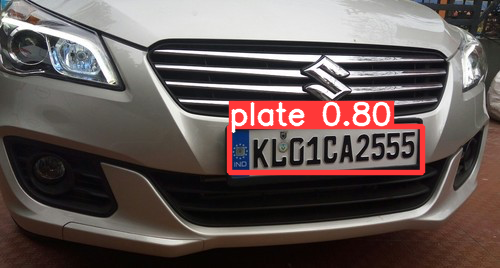

In [ ]:
from PIL import Image

# creating a object
im = Image.open("/content/yolov5/runs/detect/exp/Cars0.png")

im.show()

In [ ]:
os.chdir("/kaggle/working/yolov5/runs/train/exp")
os.listdir()

['train_batch2.jpg',
 'weights',
 'val_batch0_labels.jpg',
 'train_batch1.jpg',
 'labels.jpg',
 'PR_curve.png',
 'events.out.tfevents.1663613827.57a822265a6e.88.0',
 'results.png',
 'results.csv',
 'opt.yaml',
 'confusion_matrix.png',
 'val_batch0_pred.jpg',
 'R_curve.png',
 'hyp.yaml',
 'P_curve.png',
 'F1_curve.png',
 'labels_correlogram.jpg',
 'train_batch0.jpg']

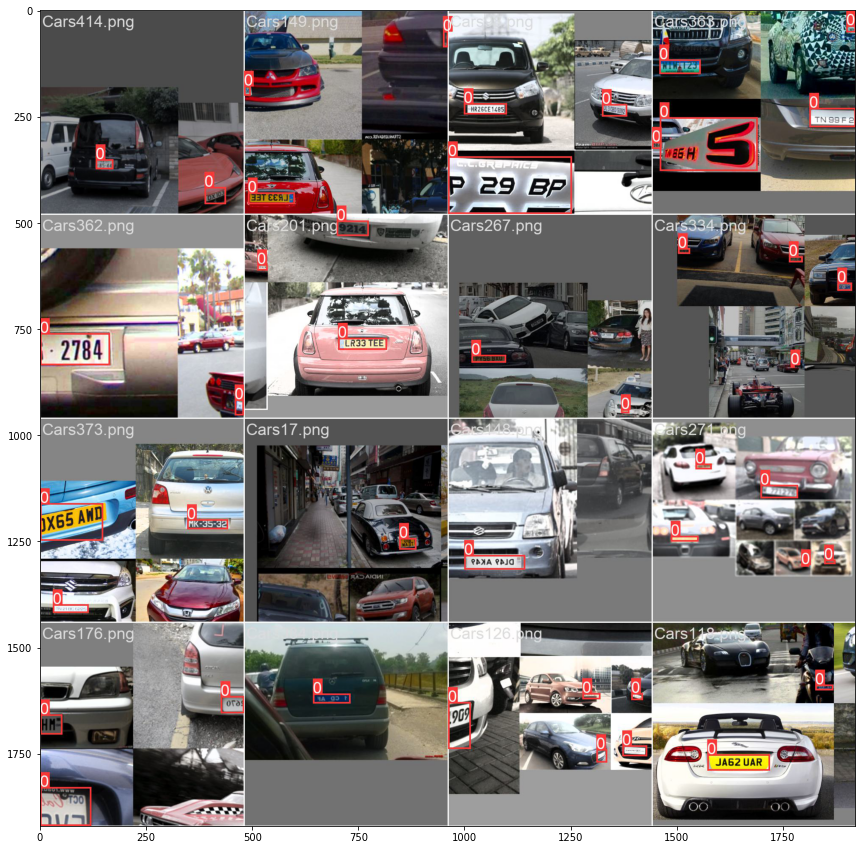

In [ ]:
plt.figure(figsize = (15, 15))
img= plt.imread('train_batch0.jpg');
plt.imshow(img);

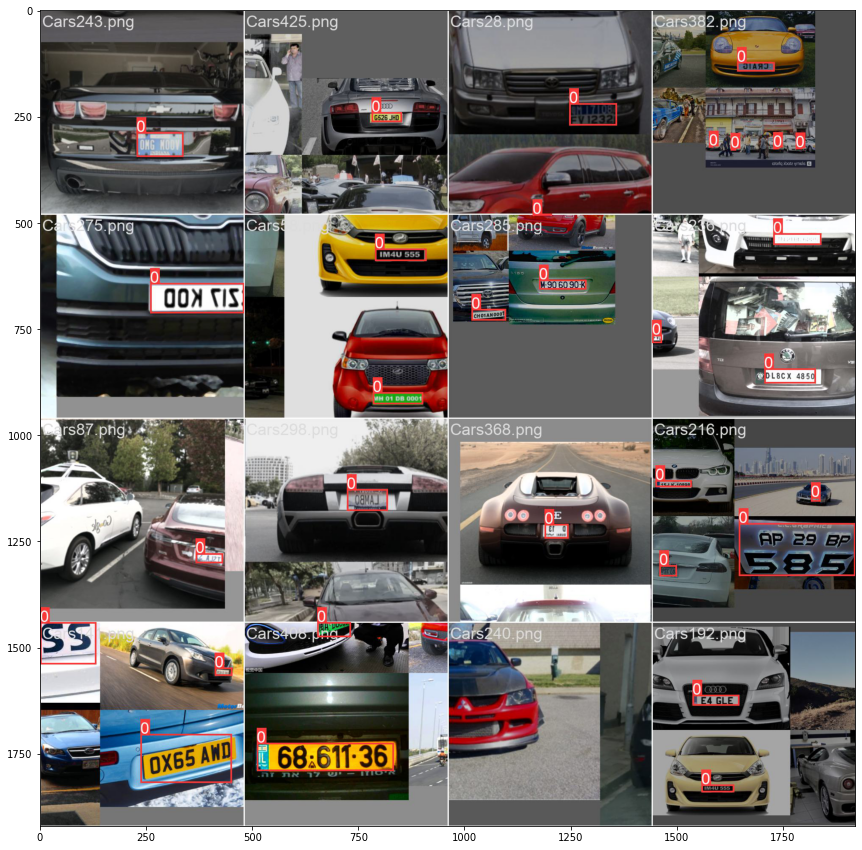

In [ ]:
try:
    plt.figure(figsize = (15, 15))
    img= plt.imread('train_batch1.jpg');
    plt.imshow(img);
except: 
    print("file has not created")

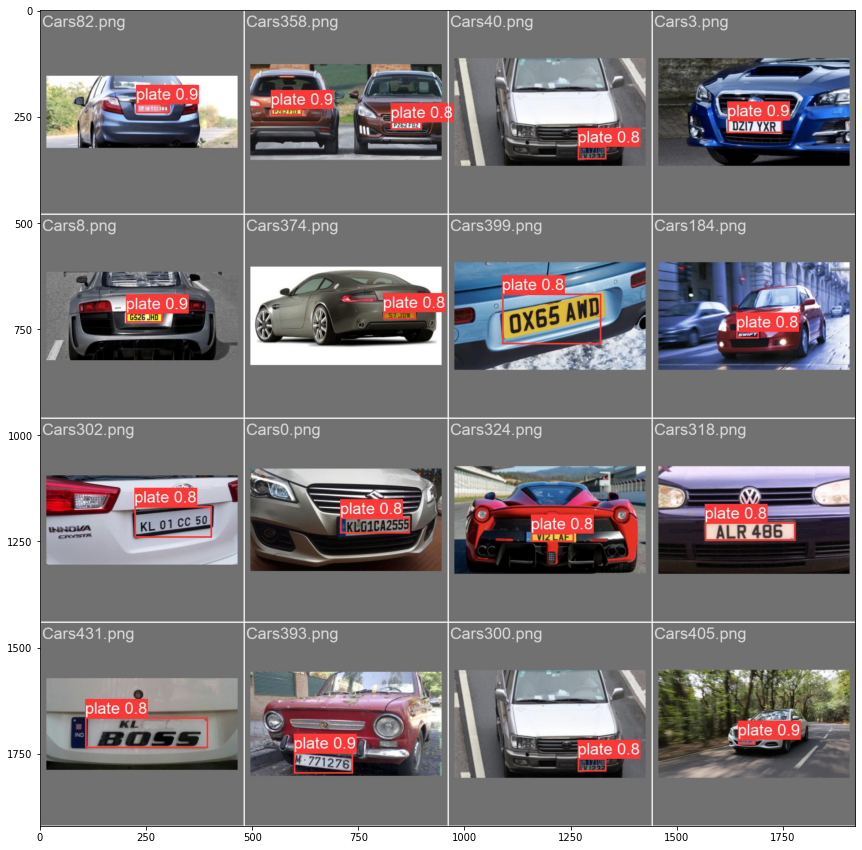

In [ ]:
try: 
    plt.figure(figsize = (15, 15))
    img= plt.imread('val_batch0_pred.jpg');
    plt.imshow(img);
except: 
    print("file was not created")

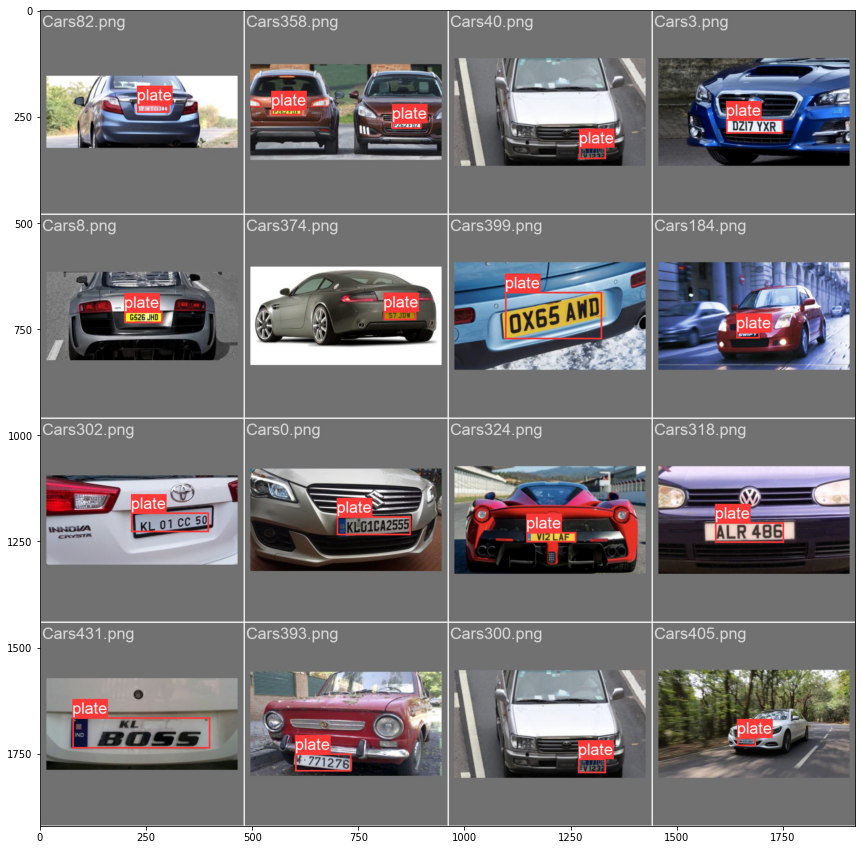

In [ ]:
try: 
    plt.figure(figsize = (15, 15))
    img= plt.imread('val_batch0_labels.jpg');
    plt.imshow(img);
except: 
    print("file was not created")